In [232]:
import pandas as pd
import numpy as np
df_equi = pd.read_excel("df_equi2.xlsx", index_col = 0)

avg_p = []
for i in range(96):
    df = df_equi.iloc[i*24:(i+1)*24]
    a = df['bp5_p'].mean()
    avg_p.append(a)


In [233]:
import prophet
from prophet import Prophet
# import logging


In [234]:
# Evaluate the model
def make_comparison_dataframe(historical, forecast):
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].merge(historical.set_index('ds'), left_index = True, right_index=True)

def calculate_forecast_errors(df, prediction_size):
    df1 = df.copy()
    df1['e'] = df1['y'] - df1['yhat']
    df1['p'] = 100 * df1['e'] / df1['y']

    predicted_part = df1[-prediction_size:]
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

In [247]:
def run_prophet(df):
    logging.getLogger().setLevel(logging.ERROR)
    import matplotlib.pyplot as plt
    name = df.columns[1]
    # Change the column names according to Prophet's guidelines
    df.columns = ['ds', 'y']
    
    # Split into a train/test set
    prediction_size = 30
    train_df = df[:-prediction_size]

    # Initialize and train a model
    m = Prophet()
    m.fit(train_df)

    # Make predictions
    future = m.make_future_dataframe(periods=prediction_size)
    forecast = m.predict(future)

    # Plot forecast
    m.plot(forecast)

    # Plot forecast's components
    m.plot_components(forecast)


    cmp_df = make_comparison_dataframe(df, forecast)

    for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size).items():
        print(err_name, err_value)

    # Plot forecast with upper and lower bounds
    plt.figure(figsize=(17, 8))
    plt.plot(cmp_df['yhat'], 'b', label = 'yhat')
    plt.plot(cmp_df['yhat_lower'], 'y', label = 'lower')
    plt.plot(cmp_df['yhat_upper'], 'g', label = 'upper')
    plt.plot(cmp_df['y'], 'r', label = 'y')
    plt.xlabel('Time')
    plt.ylabel('Average bp5_p')
    plt.title('time series forecast for '+name)
    plt.legend()
    plt.grid(False)
    plt.show()
    


In [253]:
from datetime import datetime
date = list(set([x[:8] for x in df_equi.index]))
date = [datetime.strptime(x, "%Y%m%d") for x in date]
df = pd.DataFrame(avg_p, date).reset_index()

# hour = [datetime.strptime(x, "%Y%m%d %H:%m") for x in list(df_equi.index)]


df1 = df_equi.copy()
df1.index = pd.to_datetime(df1.index)
df1 = df1.reset_index()
df1 = df1[['index','bp4_p']]



INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


MAPE 16.475705099473434
MAE 33.16105452633584


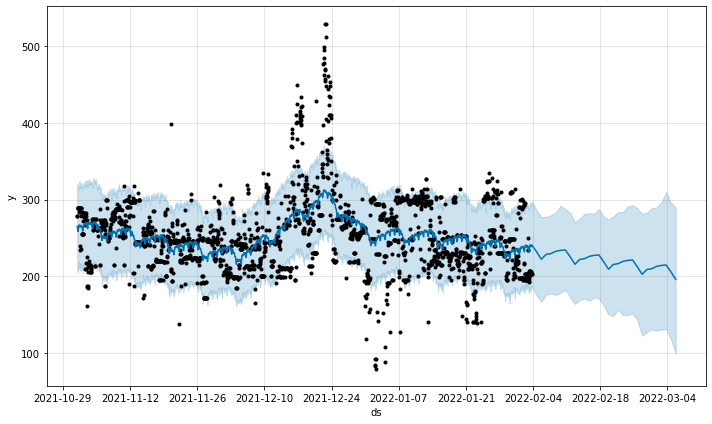

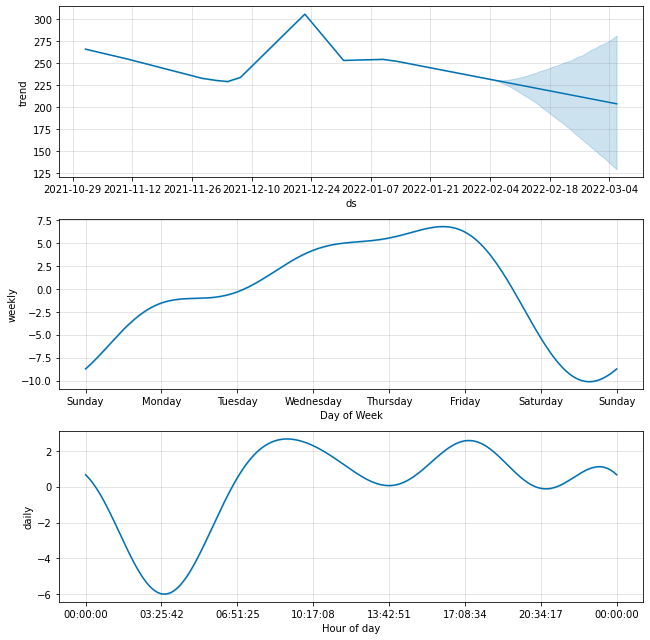

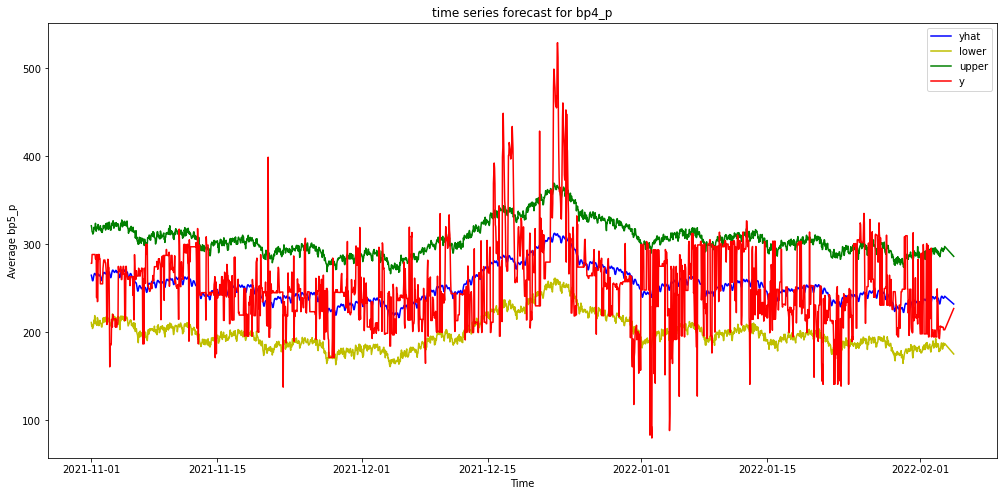

In [254]:
run_prophet(df1)